## 19.1 Домашнее задание: Neural Style Transfer

Евгений_Ибрагимов_59443663

Telegram: @superflanker

Сделано на основе учебного ноутбука с семинара

**Задача:** Буду стилизовывать картину Дали под других художников

In [2]:
from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip3 install torch torchvision
# !pip3 install pillow==4.1.1

In [4]:
%matplotlib inline
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

**Загрузка изображений**

In [5]:
imsize = 224  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style1_img = image_loader("/content/drive/MyDrive/Colab Notebooks/18. GAN и Style Transfer/StyleTransfer/images/style3.jpg") # малевич
style2_img = image_loader("/content/drive/MyDrive/Colab Notebooks/18. GAN и Style Transfer/StyleTransfer/images/style4.jpg") # канлинский
content_img = image_loader("/content/drive/MyDrive/Colab Notebooks/18. GAN и Style Transfer/StyleTransfer/images/dali1.jpg") # дали

# маска сделана руками в Paint - нужна для совмещения нескольких стилей в одном
mask_img = image_loader("/content/drive/MyDrive/Colab Notebooks/18. GAN и Style Transfer/StyleTransfer/images/mask1.png") 

Выведем то, что было загружено

In [7]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    # plt.pause(0.001) 

def inverse_mask(tensor):
    res = tensor.clone()
    res[tensor==0] = 1
    res[tensor!=0] = 0
    return res

mask_loader = lambda s: transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize(s),
    transforms.CenterCrop(s),
    transforms.ToTensor()])

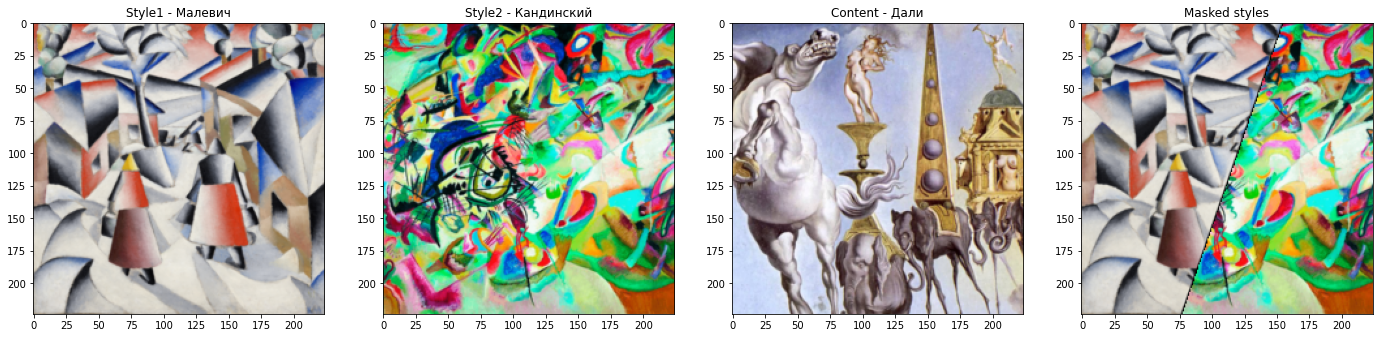

In [8]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
imshow(style1_img, title='Style1 - Малевич')

plt.subplot(1, 4, 2)
imshow(style2_img, title='Style2 - Кандинский')

plt.subplot(1, 4, 3)
imshow(content_img, title='Content - Дали')

plt.subplot(1, 4, 4)
imshow(style1_img * mask_img + style2_img * inverse_mask(mask_img), title='Masked styles')

In [9]:
def mae_loss(pred, target):
    result = torch.abs(target - pred).mean()
    return result

def mse_loss(pred, target):
    result = torch.pow(target - pred, 2).mean()
    return result

In [10]:
class ContentLoss(nn.Module):
        def __init__(self, target, loss_fn=mse_loss):
            super(ContentLoss, self).__init__()
            self.loss_fn = loss_fn
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = self.loss_fn(self.target, self.target)#to initialize with something

        def forward(self, input):
            self.loss = self.loss_fn(input, self.target)
            return input

def gram_matrix(input):
        batch_size, f_map_num, w, h = input.size()  # batch size(=1)
        features = input.reshape(batch_size * f_map_num, w * h) 
        G = torch.mm(features, features.t())  # compute the gram product
        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

class StyleLoss(nn.Module):
        def __init__(self, target_feature, mask, loss_fn=mse_loss):
            super(StyleLoss, self).__init__()

            self.loss_fn = loss_fn
            # маска будет накладываться на входящий и целевой тензор чтобы считать потеря только для части изображения (маска зануляет ненужную часть изображения)
            self.mask = mask.cpu()[0,0].numpy()
            msk = mask_loader(target_feature.size()[2])(self.mask).to(device)

            self.target = gram_matrix(target_feature * msk).detach()

            self.loss = self.loss_fn(self.target, self.target)

        def forward(self, input):
            msk = mask_loader(input.size()[2])(self.mask).to(device)

            G = gram_matrix(input * msk)
            self.loss = self.loss_fn(G, self.target)
            return input

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [12]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [13]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style2_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [14]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, style2_img, content_img, mask1_img, mask2_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default,
                                   style2_layers=style2_layers_default,
                                   loss_fn=mse_loss):
        cnn1 = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []
        style2_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn1.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature, mask1_img, loss_fn=loss_fn)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

            # добавляю дополнительные слои, чтобы считать функцию потерь для второго стиля
            if name in style2_layers:
                target2_feature = model(style2_img).detach()
                style2_loss = StyleLoss(target2_feature, mask2_img, loss_fn=loss_fn)
                model.add_module("style2_loss_{}".format(i), style2_loss)
                style2_losses.append(style2_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, style2_losses, content_losses

In [15]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [16]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, 
                       style1_img, style2_img, input_img, 
                       mask1_img, mask2_img, 
                       num_steps=500,
                       style1_weight=100000*1.0, style2_weight=100000*1.0, # дополнительный вес для второго стиля
                       content_weight=1,
                       loss_fn=mse_loss):
  
        """Run the style transfer."""
        # print('Building the style transfer model..')
        model, style1_losses, style2_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img, mask1_img, mask2_img, loss_fn=loss_fn)
        optimizer = get_input_optimizer(input_img)

        # print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style1_score = (0 + sum([sl1.loss for sl1 in style1_losses])) * style1_weight
                style2_score = (0 + sum([sl2.loss for sl2 in style2_losses])) * style2_weight
                content_score = (0 + sum([cl.loss for cl in content_losses])) * content_weight
                
                loss = style1_score + style2_score + content_score
                loss.backward()

                run[0] += 1
                if (run[0] % 50 == 0) and False:
                    print("run {}:".format(run))
                    print('Style1 Loss : {:4f}, Style2 Loss : {:4f}, Content Loss: {:4f}'.format(
                        style1_score.item(), style2_score.item(), content_score.item()))
                    print()

                return style1_score + style2_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

In [17]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


### Смешение двух стилей в одном переносе

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Tr

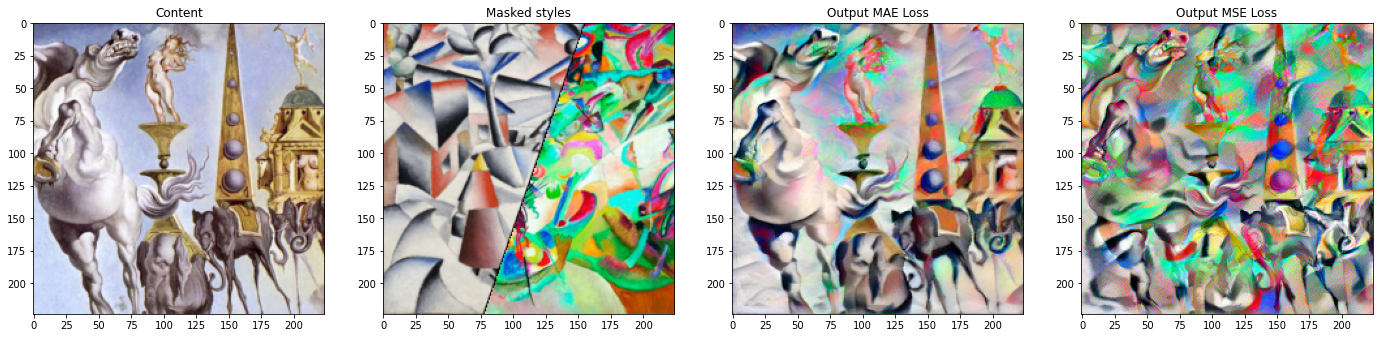

In [18]:
mask = torch.ones([1,3,imsize,imsize])

input_img = content_img.clone()
output_mae = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                                content_img, style1_img, style2_img, input_img, mask, mask, 
                                content_weight=1, loss_fn=mae_loss)

input_img = content_img.clone()
output_mse = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style1_img, style2_img, input_img, mask, mask, 
                                content_weight=1, loss_fn=mse_loss)

plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
imshow(content_img, title='Content')

plt.subplot(1, 4, 2)
imshow(style1_img * mask_img + style2_img * inverse_mask(mask_img), title='Masked styles')

plt.subplot(1, 4, 3)
imshow(output_mae, title='Output MAE Loss')

plt.subplot(1, 4, 4)
imshow(output_mse, title='Output MSE Loss')

plt.ioff()
plt.show()

### Разные стили в разных частях картинки

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


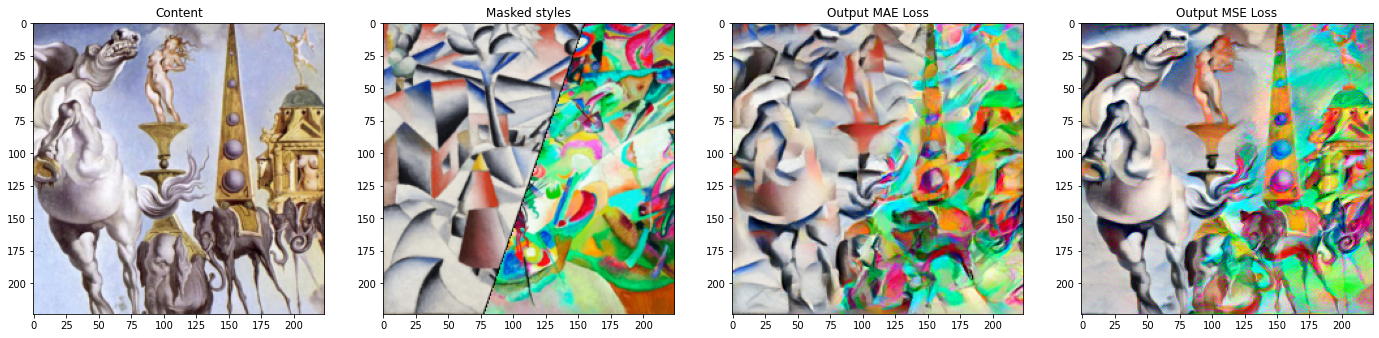

In [19]:
input_img = content_img.clone()
output_mae = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                                content_img, style1_img, style2_img, input_img, mask_img, inverse_mask(mask_img), 
                                content_weight=3, loss_fn=mae_loss)

input_img = content_img.clone()
output_mse = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                                content_img, style1_img, style2_img, input_img, mask_img, inverse_mask(mask_img), 
                                content_weight=3, loss_fn=mse_loss)

plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
imshow(content_img, title='Content')

plt.subplot(1, 4, 2)
imshow(style1_img * mask_img + style2_img * inverse_mask(mask_img), title='Masked styles')

plt.subplot(1, 4, 3)
imshow(output_mae, title='Output MAE Loss')

plt.subplot(1, 4, 4)
imshow(output_mse, title='Output MSE Loss')

plt.ioff()
plt.show()